In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset = Planetoid('./data/Planetoid', name='Cora')

In [3]:
cora = dataset[0]
cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
cora = cora.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[cora.train_mask], cora.y[cora.train_mask])
    loss.backward()
    optimizer.step()

In [12]:
model.eval()
pred = model(cora).argmax(dim=1)
correct = (pred[cora.test_mask] == cora.y[cora.test_mask]).sum()
acc = int(correct) / int(cora.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8040


In [6]:
hidden_channels = 32

In [7]:
class GATGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels, heads=4, edge_dim=1)
        self.lin1 = torch.nn.Linear(dataset.num_node_features, 4 * hidden_channels)
        
        self.conv2 = GATConv(4 * hidden_channels, hidden_channels, heads=4, edge_dim=1)
        self.lin2 = torch.nn.Linear(4 * hidden_channels, 4 * hidden_channels)
        
        
        self.conv3 = GATConv(4 * hidden_channels, dataset.num_classes, heads=6, concat=False, edge_dim=1)
        self.lin3 = torch.nn.Linear(4 * hidden_channels, dataset.num_classes)

        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.elu(self.conv1(x, edge_index, edge_attr) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index, edge_attr) + self.lin2(x))
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        return F.log_softmax(x, dim=1)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATGNN().to(device)
cora = cora.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [16]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[cora.train_mask], cora.y[cora.train_mask])
    loss.backward()
    optimizer.step()
    return loss


In [17]:
@torch.no_grad()
def test():
    model.eval()
    pred = model(cora).argmax(dim=1)
    correct = (pred[cora.test_mask] == cora.y[cora.test_mask]).sum()
    acc = int(correct) / int(cora.test_mask.sum())
    return acc


@torch.no_grad()
def test_train():
    model.eval()
    pred = model(cora).argmax(dim=1)
    correct = (pred[cora.train_mask] == cora.y[cora.train_mask]).sum()
    acc = int(correct) / int(cora.train_mask.sum())
    return acc

Epoch: 001, Loss: 1.9344, Train Acc: 0.9571, Test Acc: 0.6690
Epoch: 002, Loss: 0.9378, Train Acc: 0.9929, Test Acc: 0.7750
Epoch: 003, Loss: 0.1807, Train Acc: 0.9929, Test Acc: 0.8000
Epoch: 004, Loss: 0.0227, Train Acc: 1.0000, Test Acc: 0.7950
Epoch: 005, Loss: 0.0029, Train Acc: 1.0000, Test Acc: 0.7890
Epoch: 006, Loss: 0.0006, Train Acc: 1.0000, Test Acc: 0.7840
Epoch: 007, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 0.7840
Epoch: 008, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.7820
Epoch: 009, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7820
Epoch: 010, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7820
Epoch: 011, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7780
Epoch: 012, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7760
Epoch: 013, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7770
Epoch: 014, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7790
Epoch: 015, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7780
Epoch: 016, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7780
Epoch: 0

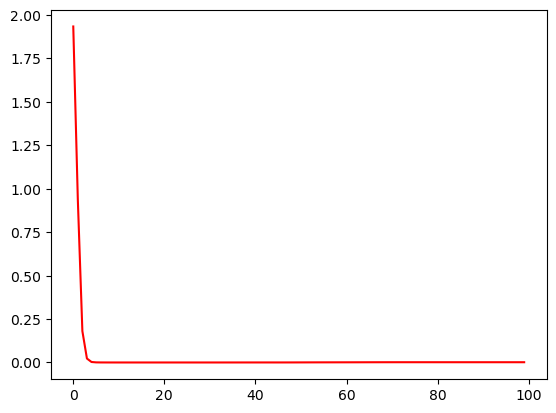

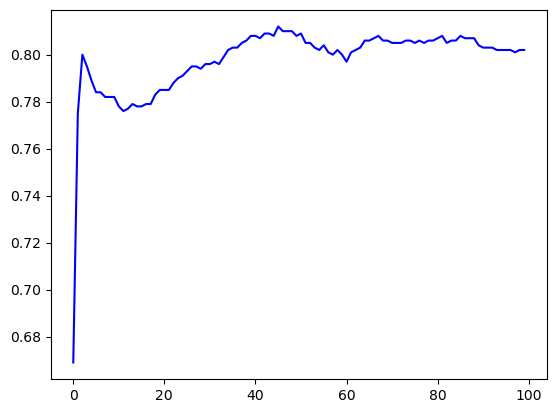

In [18]:
loss_values = []
test_acc_values = []
train_acc_values = []

for epoch in range(1, 101):
    loss = train()
    train_acc = test_train()
    test_acc = test()
    
    loss_values.append(loss.item())
    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


plt.plot(loss_values, 'r',)
plt.savefig('loss_cora_nc.png')
plt.show()
plt.plot(test_acc_values, 'b')

plt.savefig('acc_cora_nc.png')
plt.show()